In [202]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(6)

In [203]:
database = 'basketball.sqlite' 
conn = sqlite3.connect(database)

# Predict position using player attributes



## K-NN

In [204]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [205]:
Player_Attributes = pd.read_sql("""SELECT *
                        FROM Player_Attributes ; """, conn)

Player_Attributes = Player_Attributes[(~np.isnan(Player_Attributes['HEIGHT'])) &
                              (~np.isnan(Player_Attributes['WEIGHT'])) &
                              (~np.isnan(Player_Attributes['PTS'])) &
                              (~np.isnan(Player_Attributes['AST'])) &
                              (~np.isnan(Player_Attributes['REB'])) &
                              (Player_Attributes['DRAFT_ROUND'] != 'Undrafted')&
                              (Player_Attributes['DRAFT_ROUND'] != "None")&
                              (Player_Attributes['DRAFT_NUMBER'] != "None")]
Player_Attributes['DRAFT_NUMBER'] = pd.to_numeric(Player_Attributes['DRAFT_NUMBER'].copy())
Player_Attributes['DRAFT_ROUND'] = pd.to_numeric(Player_Attributes['DRAFT_ROUND'].copy())

df_X = Player_Attributes[['HEIGHT', 'WEIGHT', 'DRAFT_NUMBER', 'DRAFT_ROUND', 'SEASON_EXP', 'REB', 'AST', 'PTS']]
df_y = Player_Attributes[['POSITION']]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, train_size=0.8, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.875, random_state=0)

In [206]:
# We use a 70-10-20 train-validation-test split
print("Train set: ", X_train.shape)
print("Val set: ", X_val.shape)
print("Test set: ", X_test.shape)

Train set:  (2148, 8)
Val set:  (307, 8)
Test set:  (614, 8)


In [207]:
train_acc = []
val_acc = []

best_train_acc = 0
best_val_acc = 0
best_train_k = 0
best_val_k = 0

# Calculating error for K values between 2 and 40
for i in range(2, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train.values.ravel())
    train_accuracy = accuracy_score(y_train.values, knn.predict(X_train))
    val_accuracy = accuracy_score(y_val.values, knn.predict(X_val))
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)
    
    if train_accuracy > best_train_acc:
        best_train_acc = train_accuracy
        best_train_k = i
        
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_val_k = i


In [208]:
print('Best training accuracy is', best_train_acc, ', at k =', best_train_k)
print('Best validation accuracy is', best_val_acc, ', at k =', best_val_k)

Best training accuracy is 0.7993482309124768 , at k = 2
Best validation accuracy is 0.7035830618892508 , at k = 12


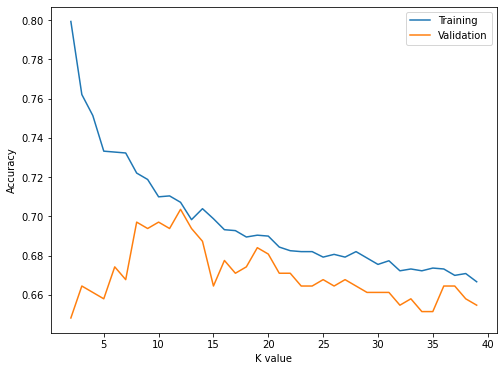

In [209]:
# graph accuracies
plt.figure(figsize=(8, 6)) 
plt.plot(range(2,40), train_acc, label='Training')
plt.plot(range(2,40), val_acc, label='Validation')
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that our testing accuracy is maximized at k = 12, while training accuracy pretty steadily decreases as k increases. Therefore we choose k = 12 as our optimal number of neighbors. 

In [210]:
# Train our KNN classifier with k = 12
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train, y_train.values.ravel())

# Get errors
print('train accuracy:', accuracy_score(y_train.values, knn.predict(X_train)))
print('test accuracy:', accuracy_score(y_test.values, knn.predict(X_test)))

train accuracy: 0.707169459962756
test accuracy: 0.6742671009771987


0.674 is not a very high accuracy on our test set.  If we compare the plot of predicted positions with the plot of true positions, we can see what is going on.

In [211]:
# Define function for plotting
def plot_predict_vs_true(X, y, y_pred, x_axis_var, y_axis_var):
    df_plot = X.copy()
    df_plot['POSITION'] = y_pred

    # plot all predictions
    groups = df_plot.groupby('POSITION')
    plt.figure(figsize=(9, 6)) 
    for name, group in groups:
        plt.plot(group[x_axis_var], group[y_axis_var], marker='o', linestyle='', label=name)

    plt.xlabel(x_axis_var)
    plt.ylabel(y_axis_var,)
    plt.legend()
    plt.title('Predicted Labels')
    plt.show()

    # plot actual values
    df_plot2 = X.copy()
    df_plot2['POSITION'] = y

    groups2 = df_plot2.groupby('POSITION')
    plt.figure(figsize=(9, 6)) 
    for name, group in groups2:
        plt.plot(group[x_axis_var], group[y_axis_var], marker='o', linestyle='', label=name)

    plt.xlabel(x_axis_var)
    plt.ylabel(y_axis_var)
    plt.legend()
    plt.title('True Labels')
    plt.show()
    

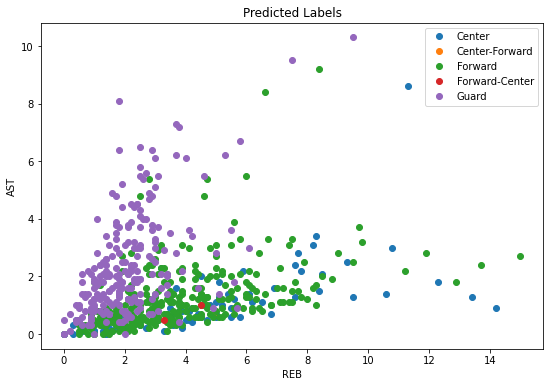

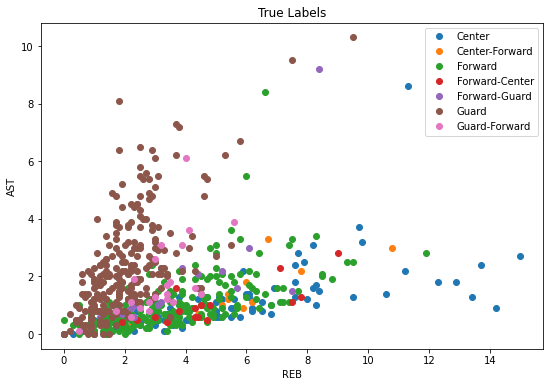

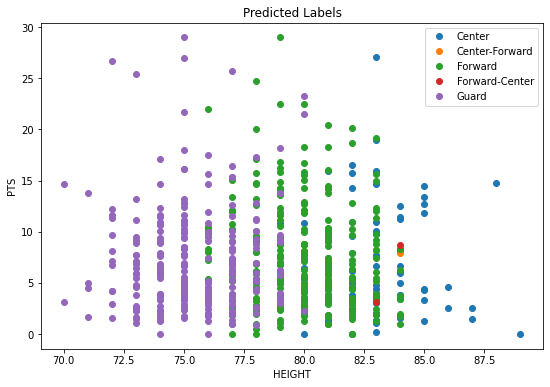

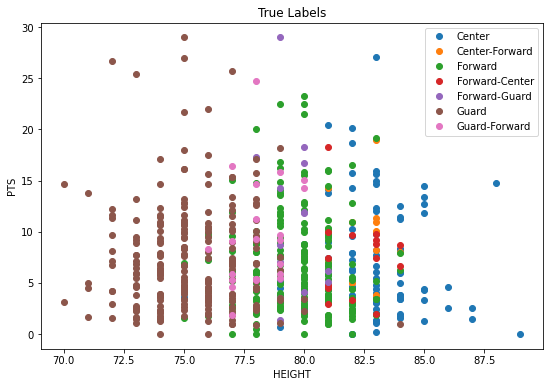

In [212]:
# Plot using 2 different combination of variables for visualization
plot_predict_vs_true(X_test, y_test, knn.predict(X_test), 'REB', 'AST')
plot_predict_vs_true(X_test, y_test, knn.predict(X_test), 'HEIGHT', 'PTS')

From the above plots, we can see that our K-NN classifier only assigns 5 of the 7 positions to our test set. We can also see from out plots that it seems to have trouble distinguishing between positions with combination names (ie. Forward-Guard and Guard). If we consider these positions the same, we can see that our classifier does in fact predict positions pretty well. However, we ideally would like our classifier to distinguish between these dual-position classifications. 

## Random Forest

We will now attempt the same classification problem as above, but this time we will train a Random Forest classifier to see if we can achieve a higher accuracy. 

In [213]:
from sklearn.ensemble import RandomForestClassifier

In [214]:
# Function to tune RandomForest model hyperparameters
def tune_hyperparams(X_train, y_train, X_val, y_val):
    max_depth = [1, 5, 10]
    n_estimators = [1, 10, 50, 100]

    # initialize
    best_accuracy = 0
    best_max_depth = 0
    best_n_estimators = 0 

    for m_depth in max_depth:
        for n_est in n_estimators:
            # train model
            clf = RandomForestClassifier(random_state=0, 
                                         max_depth=m_depth, n_estimators=n_est)
            clf.fit(X_train, y_train.values.ravel())
            # predict on validation set
            y_pred_val = clf.predict(X_val)
            # calculate accuracy on validation set
            acc = accuracy_score(y_val.values, y_pred_val)
            # store if better than best so far
            if acc > best_accuracy:
                best_accuracy = acc
                best_max_depth = m_depth
                best_n_estimators = n_est

    return best_accuracy, best_max_depth, best_n_estimators

In [215]:
# Tune model
best_accuracy, best_max_depth, best_n_estimators = tune_hyperparams(X_train, y_train, 
                                                                    X_val, y_val)

print('Best validation accuracy:', best_accuracy)
print('max_depth:', best_max_depth)
print('n_estimators:', best_n_estimators)

Best validation accuracy: 0.7850162866449512
max_depth: 10
n_estimators: 10


In [216]:
# Train model with optimal hyperparameters
model = RandomForestClassifier(n_estimators = 10, random_state = 0, max_depth = 10)
model.fit(X_train, y_train.values.ravel())

print('train accuracy:', accuracy_score(y_train.values, model.predict(X_train)))
print('test accuracy:', accuracy_score(y_test.values, model.predict(X_test)))

train accuracy: 0.898975791433892
test accuracy: 0.752442996742671


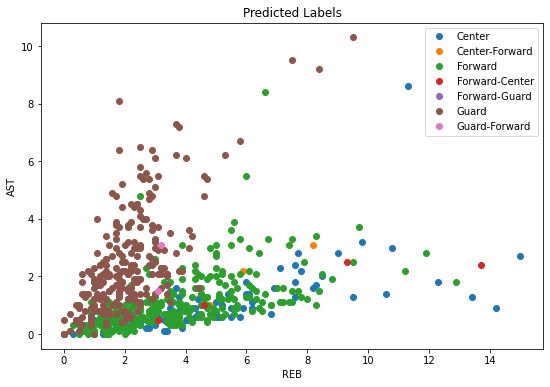

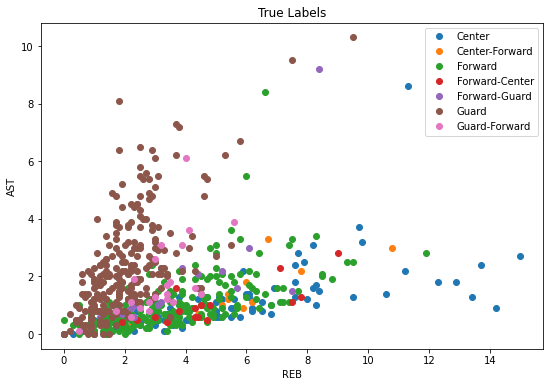

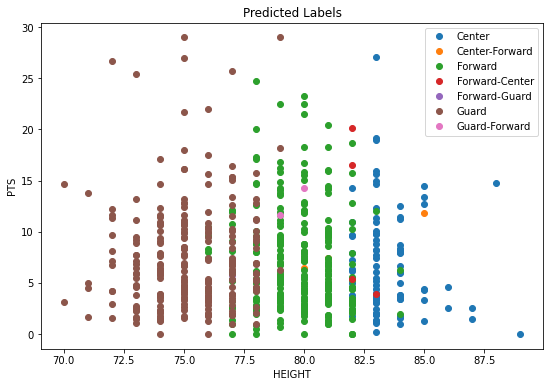

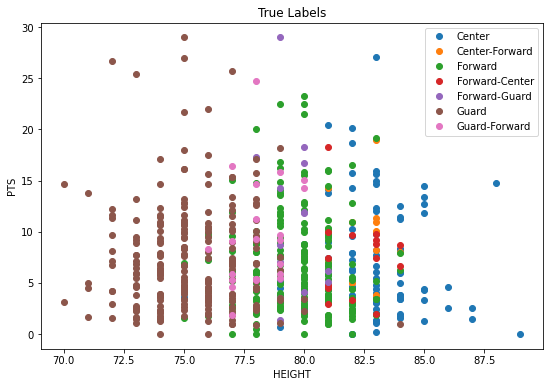

In [217]:
# Plot using 2 different combination of variables for visualization
plot_predict_vs_true(X_test, y_test, model.predict(X_test), 'REB', 'AST')
plot_predict_vs_true(X_test, y_test, model.predict(X_test), 'HEIGHT', 'PTS')

With our tuned Random Forest model, we were able to achieve an accuracy of 0.752 on the test set. This is a big improvement from our test accuracy of 0.674 using K-NN. Also, notice that our Random Forest classifier assigns all 7 position labels in its predictions. Thus, we have improved both the accuracy of our classifier, as well as its ability to distinguish between dual-position classifications, as was our goal. 